<a href="https://colab.research.google.com/github/ropas5/eye_diseases_classification_trabajo_DL/blob/main/nootbooks/01_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importamos los datos desde kaggle, creando la carpeta de data, con los datos comprmidos ( como se descarga por defecto de kaggle), y ha continuacion descomprimimos las carpetas con las imagenes

Versión de Colab

In [2]:
!pip install kaggle

from google.colab import files
import os, zipfile
from glob import glob

# Subir kaggle.json
files.upload()
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

path = "data/raw"

# Descargar
os.makedirs(path, exist_ok=True)
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification -p "{path}" --force

with zipfile.ZipFile(path + "/eye-diseases-classification.zip", 'r') as zip_ref:
    zip_ref.extractall(path)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
 77% 568M/736M [00:00<00:00, 2.77GB/s]
100% 736M/736M [00:00<00:00, 2.11GB/s]


Versión en local

In [3]:
# import os
# import zipfile

# path = "../data/raw"

# if not os.path.exists(path):
#     os.makedirs(path)

# #Descarga de datos desde kaggle
# !kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification -p path

# #Descomprimir zip
# with zipfile.ZipFile(path +"/eye-diseases-classification.zip", 'r') as zip_ref:
#     zip_ref.extractall(path)

## Preprocesamiento de los datos

In [4]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm

path = path + "/dataset"
target_size = (512, 512)

imgs = []
labels = []
folders = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

for folder in tqdm(folders):
    folder_path = os.path.join(path, folder) #Creamos la direccion de cada carpeta
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) #obtenemos direccion de cada archivo
        try:
            with Image.open(fpath) as img:
                img = img.convert("RGB") # Lectura de image
                img = img.resize(target_size)
                arr = np.array(img)
            imgs.append(arr)
            labels.append(folder)
        except Exception as e:
            print("skip:", fpath, str(e))

X = np.stack(imgs)
y = np.array(labels)


100%|██████████| 4/4 [00:29<00:00,  7.30s/it]


## EDA

In [5]:
print("Tamaño del dataframe:", X.shape)
print("Tamaño de una imagene:", X[0].shape)

#Comprobamos que todas las imagenes tengan el mismo tamaño:
shapes = [img.shape for img in imgs]
unique_shapes = set(shapes)

print("Dimensiones encontradas:", unique_shapes)

Tamaño del dataframe: (4217, 512, 512, 3)
Tamaño de una imagene: (512, 512, 3)
Dimensiones encontradas: {(512, 512, 3)}


Visualizacion de imagenes

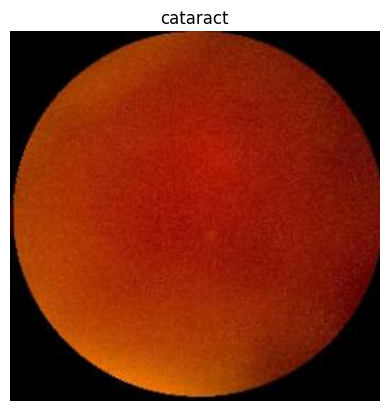

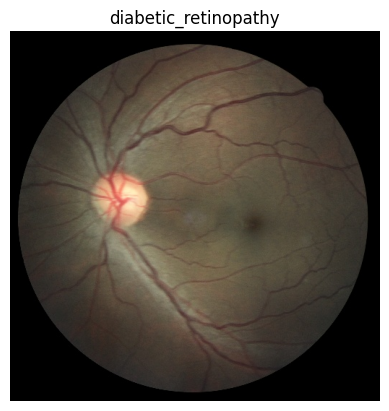

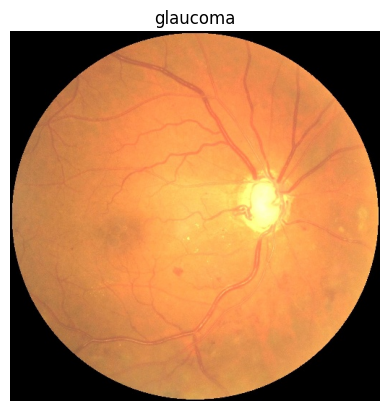

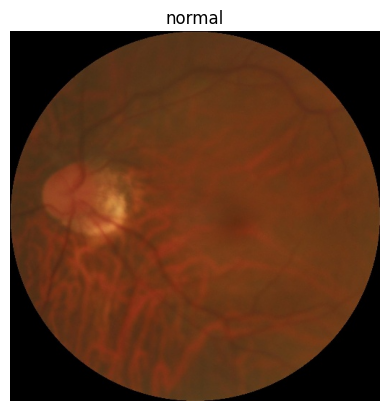

In [6]:
import matplotlib.pyplot as plt

classes = np.unique(y)

for label in classes:
    idx = np.where(y == label)[0][0]   # primer índice de esa clase
    plt.imshow(X[idx])
    plt.title(label)
    plt.axis("off")
    plt.show()

Distribución de las categorias

In [7]:
classes, counts = np.unique(y, return_counts=True)
percentages = counts / counts.sum() * 100

df_counts = pd.DataFrame({
    "clase": classes,
    "n_imagenes": counts,
    "porcentaje": percentages.round(2)
})

df_counts

,clase,n_imagenes,porcentaje
0,cataract,1038,24.61
1,diabetic_retinopathy,1098,26.04
2,glaucoma,1007,23.88
3,normal,1074,25.47


El conjunto de datos está formado por 4217 imágenes RGB de tamaño 512x512.
Todas las imágenes fueron redimensionadas al mismo tamaño, para poder aplicar facilmente la CNN.
La distribución de clases es la siguiente:
- normal 25.47%
- diabetic retinopathy 26.04%
- cataract 24.61%
- glaucoma 23.88%

Podemos ver como las clases estas bien distribuidas.

# Primeros Modelos
Modificamos la Y para tenerla como numero y no texto

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_int = le.fit_transform(y)

In [21]:
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y_int, num_classes=4)

In [22]:
from sklearn.model_selection import train_test_split
random=42

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, train_size=0.7 ,random_state=random ,shuffle=True)

In [30]:
from sklearn.metrics import f1_score

results = pd.DataFrame(columns=[
    "model_name",
    "normalized",
    "epochs",
    "train_acc",
    "val_acc",
    "f1_test"])

def df_result(nombre, norm, model, hist):
  global results, X_test, y_test

  # Predecimos sobre el set de validación o test
  y_pred = model.predict(X_test)
  y_pred_classes = y_pred.argmax(axis=1) # convertimos a enteros

  # F1-score macro (igual peso a todas las clases)
  f1 = f1_score(y_test)

  new_row = {
        "model_name": nombre,
        "normalized": norm,
        "epochs": len(hist.history["accuracy"]),
        "train_acc": hist.history["accuracy"][-1],
        "val_acc": hist.history["val_accuracy"][-1],
        "f1_test": f1
  }
  results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)


In [28]:
#Modelo basico
!pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout, MaxPooling2D
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


# create sequential model Basic network
model = Sequential()

# We add layers
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(512,512,3)))

model.add(Flatten())
model.add(Dense(4, activation='softmax'))

optimizer_adam = Adam()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01)

model.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=1, callbacks=[early_stopping])

df_result("Basic", False, hist)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.4170 - loss: 20959.4414 - val_accuracy: 0.5946 - val_loss: 147.1975


In [29]:
# create sequential model Basic network
model = Sequential()

# We add layers
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(512,512,3)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

optimizer_adam = Adam()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01)

model.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=1, callbacks=[early_stopping])

# Guardamos los resultados en un el df
df_result("Basic+BatchNormalization", False, hist)

83/83 ━━━━━━━━━━━━━━━━━━━━ 387s 5s/step - accuracy: 0.5225 - loss: 652.7003 - val_accuracy: 0.4966 - val_loss: 779.0629
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 720ms/step


TypeError: missing a required argument: 'y_pred'

Normalizamos los datos para obtener mejor resultado

In [31]:
X_train_norm = X_train.astype("float32")/255.0
X_test_norm = X_test.astype("float32")/255.0

In [ ]:
# create sequential model Basic network
model = Sequential()

# We add layers
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(512,512,3)))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

optimizer_adam = Adam()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01)

model.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=1, callbacks=[early_stopping])

# Guardamos los resultados en un el df
df_result("Basic+Normlais", True, hist)

In [33]:
os.makedirs(path+"processed", exist_ok=True)
results.to_csv("data/processed/model_results.csv", index=False)

OSError: Cannot save file into a non-existent directory: 'data/processed'